In [1]:
import sys
import os

# Get absolute paths
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
octagon_analysis = os.path.join(parent_dir, "octagon_analysis")
main_copy_dir = os.path.join(parent_dir, "main_copy")

# Ensure octagon_analysis is searched first
sys.path.insert(0, octagon_analysis)
sys.path.append(main_copy_dir)  # Lower priority

print("Added paths to sys.path", sys.path[:2])  # Optional for debugging


Added paths to sys.path ['/Users/benny/Desktop/MSc/Project/Git/repos/octagon_analysis', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip']


In [2]:
# imports
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import analysis.opponent_visibility as opponent_visibility
import trajectory_analysis.trajectory_vectors as trajectory_vectors
import trajectory_analysis.trajectory_headangle as trajectory_headangle
import trajectory_analysis.trajectory_direction as trajectory_direction
import data_extraction.trial_list_filters as trial_list_filters
import data_extraction.get_indices as get_indices
from plotting import plot_octagon, plot_trajectory
import utils.cosine_similarity as cosine_similarity
import data_extraction.extract_trial as extract_trial
import parse_data.identify_filepaths as identify_filepaths
import analysis.loser_inferred_choice as loser_inferred_choice
import plotting.flipped_rotated_trajectory_testing_functions as flipped_rotated_trajectory_testing_functions


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# data folder and filenames
data_folder = "/Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files"

social_files, ordered_solos = identify_filepaths.get_filenames(data_folder=data_folder)

In [4]:
# single json filename

json_filename = social_files[17]

In [5]:
_, trial_list = prepare_data.prepare_data(data_folder, json_filename, combine=True)

filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/241220_1/2024-12-20_17-44-50_KS20_CS20_Social.json
Loading complete.
Preprocessing complete.


In [52]:
# pick arbitrary test trial
trial = trial_list[4]
trial_index = 4
loser_id = loser_ids[4]

In [53]:
# get winner and loser ids for the whole session
winner_ids = get_indices.get_trigger_activators(trial_list)
loser_ids = (winner_ids -1) * -1

trial_walls = get_indices.get_walls(trial=trial)

In [54]:
# get trajectory for loser
trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=loser_id)

# ignore first part of trajectory
trajectory_end = loser_inferred_choice.extract_final_third_trajectory(trajectory)

In [55]:
# get loser direction vectors 
smoothed_player_vectors = trajectory_direction.get_smoothed_player_direction_vectors_for_trajectory(trajectory_end,window_size=5)

In [70]:

player_to_alcove_vectors = trajectory_vectors.get_player_to_alcove_direction_vectors_for_trajectory(smoothed_player_vectors, num_walls = 8)

-0.019103431701660158 -0.20735535621643067
12.287965774536133 -3.9770028591156006


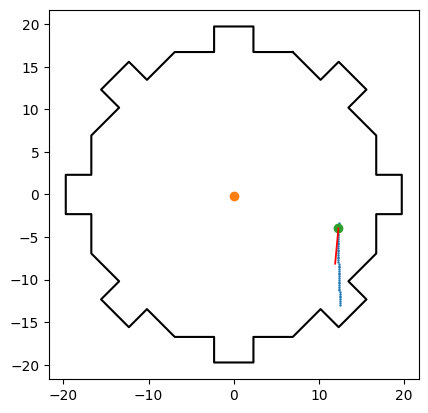

In [15]:
# plot direction vectors
ax = plot_octagon.plot_octagon()
ax.scatter(trajectory_end[0,:], trajectory_end[1,:], s=0.5)
time_index=3

x_start = trajectory_end[0,time_index]
y_start = trajectory_end[1,time_index]
x_vector = smoothed_player_vectors[0,time_index]
y_vector = smoothed_player_vectors[1,time_index]
vector_length = 20

start = [x_start, y_start]
end = [x_start + x_vector * vector_length, y_start + y_vector * vector_length]

ax.scatter(x_vector, y_vector)
print(x_vector, y_vector)
ax.scatter(x_start, y_start)
print(x_start, y_start)
#start = [x_start, y_start]
#end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]

this_head_angle_vector_coordinates = np.array(list(zip(start,end)))
ax.plot(this_head_angle_vector_coordinates[0,:], this_head_angle_vector_coordinates[1,:], c='r', linewidth=1.3)


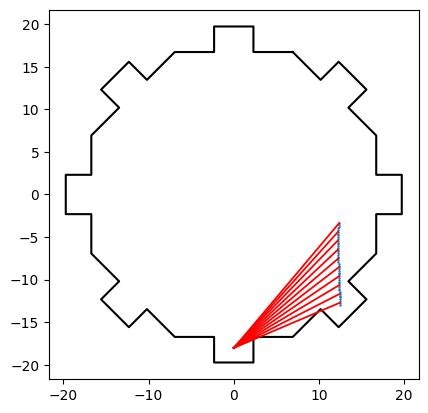

In [74]:
ax = plot_octagon.plot_octagon()
ax.scatter(trajectory_end[0,:], trajectory_end[1,:], s=0.5)

for time_index in range(0, player_to_alcove_vectors[0].shape[1],5):
    x_start = trajectory_end[0,time_index]
    y_start = trajectory_end[1,time_index]
    x_alcove = player_to_alcove_vectors[0][4][time_index]
    y_alcove = player_to_alcove_vectors[1][4][time_index]
    vector_length = 3

    start = [x_start, y_start]
    end = [x_alcove, y_alcove]
    #start = [x_start, y_start]
    #end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]
    
    this_head_angle_vector_coordinates = np.array(list(zip(start,end)))
    ax.plot(this_head_angle_vector_coordinates[0,:], this_head_angle_vector_coordinates[1,:], c='r', linewidth=1.3)


In [ ]:
ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

for time_index in range(0, player_to_alcove_vectors[0].shape[1],5):
    x_start = trajectory[0,time_index]
    y_start = trajectory[1,time_index]
    x_alcove = player_to_alcove_vectors[0][3][time_index]
    y_alcove = player_to_alcove_vectors[1][3][time_index]
    vector_length = 3

    start = [x_start, y_start]
    end = [x_alcove, y_alcove]
    #start = [x_start, y_start]
    #end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]
    
    this_head_angle_vector_coordinates = np.array(list(zip(start,end)))
    ax.plot(this_head_angle_vector_coordinates[0,:], this_head_angle_vector_coordinates[1,:], c='r', linewidth=1.3)


In [ ]:
# FUNCTIONS

In [50]:
def cosine_similarity_throughout_trajectory(trajectory, window_size=10, num_walls=8, calculate_thetas=False, debug=False):
    ''' From a trajectory, calculate the cosine similarity between the player direction vector and 
        the player-to-alcove vectors for an entire trial
        Takes a 2*timepoints array of vstacked x_coords and y_coords
        Returns an array of shape num_walls*timepoints 
        if calculate_thetas, also returns an angles (rad) array of shape num_walls*timepoints'''

    # 1. find the direction vectors for a player at each timepoint, smoothed with a rolling window
    smoothed_player_vectors = trajectory_direction.get_smoothed_player_direction_vectors_for_trajectory(trajectory,
                                                                                   window_size=window_size)
    if debug:
        print("smoothed_player_vectors.shape: ", smoothed_player_vectors.shape)

    
    # 2. find the player-to-alcove vectors for each wall, for each timepoint
    player_to_alcove_vectors = trajectory_vectors.get_player_to_alcove_direction_vectors_for_trajectory(trajectory, num_walls=8, debug=False)
    if debug:
        print("player_to_alcove_vectors.shape: ", player_to_alcove_vectors.shape)


    
    # 3. calculate the dot products between the two sets of vectors 
    dot_products_trajectory = trajectory_vectors.calculate_vector_dot_products_for_trajectory(player_to_alcove_vectors,
                                                                           smoothed_player_vectors,
                                                                           num_walls=num_walls)
    if debug:
        print("dot_products_trajectory.shape: ", dot_products_trajectory.shape)
        print("dot_products_trajectory\n", dot_products_trajectory[:,:10])
    
    
    # 4. calculate the norms for the two sets of vectors
    (direction_vector_norms_trajectory,
     player_to_alcove_vector_norms_trajectory) = trajectory_vectors.calculate_vector_norms_for_trajectory(player_to_alcove_vectors,
                                                                                       smoothed_player_vectors,
                                                                                       num_walls=8)
    if debug:
        print("direction_vector_norms_trajectory.shape: ", direction_vector_norms_trajectory.shape)
        print("player_to_alcove_vector_norms_trajectory.shape: ", player_to_alcove_vector_norms_trajectory.shape)
        
        print("direction_vector_norms_trajectory\n", direction_vector_norms_trajectory[:10])
        print("player_to_alcove_vector_norms_trajectory\n", player_to_alcove_vector_norms_trajectory[:,:10])
    
    
    # 5. calculate cosine similarity for the direction vector as compared to the vector from the player to each wall
    # this is done for all timepoints in a trajectory
    cosine_similarities_trajectory = trajectory_vectors.calculate_cosine_similarity_for_trajectory(dot_products_trajectory,
                                                                                 direction_vector_norms_trajectory,
                                                                                 player_to_alcove_vector_norms_trajectory,
                                                                                 num_walls=8)
    
    if debug:
        print("cosine_similairities_trajectory.shape: ", cosine_similarities_trajectory.shape)


    # return a num_walls*timepoints shaped array of cosine similarities
    # additionally return a num_walls*timepoints shapped array of angles between the direction vectors and the player-to-wall 
    # vectors if specified
    if calculate_thetas:
        thetas_trajectory = trajectory_vectors.calculate_thetas_for_trajectory(cosine_similarities_trajectory)
        return cosine_similarities_trajectory, thetas_trajectory
    else:
        return cosine_similarities_trajectory

In [56]:
cosine_similarities_trajectory = cosine_similarity_throughout_trajectory(trajectory_end, window_size=10, num_walls=8, calculate_thetas=False, debug=False)

In [57]:
average_most_aligned_wall_index = loser_inferred_choice.average_most_aligned_wall_trajectory(cosine_similarities_trajectory)

In [58]:
average_most_aligned_wall_index

np.int64(3)

In [45]:
cosine_similarities_trajectory_prev = trajectory_direction.cosine_similarity_throughout_trajectory(trajectory, window_size=10, num_walls=8, calculate_thetas=False, debug=False)

In [46]:
average_most_aligned_wall_index_prev = loser_inferred_choice.average_most_aligned_wall_trajectory(cosine_similarities_trajectory_prev)

In [47]:
average_most_aligned_wall_index_prev

np.int64(4)

In [59]:
def infer_loser_choice_trial(trial_list, trial_index, loser_ids, trial_walls, window_size=5):
    ''' Given a trial list and index, and 1D array of loser id ints, find the most
        aligned wall for the loser in the latter part of their trajectory, and decide
        whether this most aligned wall should be considered their choice.
        For a single trial.
        Returns: scalar wall most aligned with on average, boolean confidence of loser's choice. '''
    
    # LVs 
    losers_choice_accepted = False
    
    # get trial and loser id
    trial = trial_list[trial_index]
    loser_id = loser_ids[trial_index]

    # get trajectory for loser
    trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=loser_id)
    
    # ignore first part of trajectory
    trajectory_end = loser_inferred_choice.extract_final_third_trajectory(trajectory)
    
    # find cosine similarities between trajectory direction vector and player-alcove vectors for each wall
    cosine_similarity_trajectory = cosine_similarity_throughout_trajectory(trajectory_end,
                                                                            window_size=window_size,
                                                                            num_walls=8,
                                                                            calculate_thetas=False)
    # find the most aligned wall (mean average)
    average_most_aligned_wall_index = loser_inferred_choice.average_most_aligned_wall_trajectory(cosine_similarity_trajectory)
    print(average_most_aligned_wall_index)
    average_most_aligned_wall_num = average_most_aligned_wall_index + 1
    highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))

    mean_alignments = np.nanmean(cosine_similarity_trajectory, axis=1)
    sorted_indices = np.argsort(mean_alignments)[::-1]
    second_highest_alignment_index = sorted_indices[1]
    second_most_aligned_wall_num = second_highest_alignment_index + 1
    second_highest_alignment_val = mean_alignments[second_highest_alignment_index]

    # find the distance to the most aligned wall at the final trajectory timepoint
    final_distance_most_aligned_wall = loser_inferred_choice.final_distance_to_wall(trajectory, average_most_aligned_wall_index)

    if highest_alignment_val > 0.875 and average_most_aligned_wall_num in trial_walls:
        losers_choice_accepted = True
    elif final_distance_most_aligned_wall < 4 and average_most_aligned_wall_num in trial_walls:
        losers_choice_accepted = True
    

    # check if second most aligned value is very close to first
    alignment_threshold = 0.05

    if abs(highest_alignment_val - second_highest_alignment_val) < alignment_threshold:
        print(f"ambiguous trial: second-highest alignment ({second_highest_alignment_val}) is very close to the highest {highest_alignment_val}.")

    else:
        print(f"most aligned wall is valid")

    return average_most_aligned_wall_num, losers_choice_accepted, highest_alignment_val, second_most_aligned_wall_num, second_highest_alignment_val


In [60]:
(average_most_aligned_wall_num, losers_choice_accepted,
 highest_alignment_val, second_most_aligned_wall_num, second_highest_alignment_val) = infer_loser_choice_trial(trial_list, trial_index, loser_ids, trial_walls, window_size=5)



3
most aligned wall is valid


In [61]:
# ambiguity array
ambiguity_array = np.zeros((9, 14), dtype=int)

# return tuples for most aligned wall, secon most aligned wall
# and highest alignment val, second highest alignment val
alignment_results = []
ambiguous_trial_indices = []

for trial_index in range(len(trial_list)):
    print(f"trial index: {trial_index}")

    average_most_aligned_wall_num, losers_choice_accepted, highest_alignment_val, second_most_aligned_wall_num, second_highest_alignment_val = infer_loser_choice_trial(
        trial_list, trial_index, loser_ids, trial_walls, window_size=5)

    # check for ambiguity
    if abs(highest_alignment_val - second_highest_alignment_val) < 0.05:
        #print(f"ambiguous trial {trial_index}: second-highest alignment ({second_highest_alignment_val}) is very close to the highest {highest_alignment_val}.")
        # set corresponding position in binary array to 1
        row = trial_index // 14
        col = trial_index % 14
        print(row)
        ambiguity_array[row, col] = 1
        ambiguous_trial_index = trial_index
        ambiguous_trial_indices.append(ambiguous_trial_index)
    #else:
        #print("most aligned wall is valid")

    result = (int(average_most_aligned_wall_num), int(second_most_aligned_wall_num),
              (np.round(highest_alignment_val, 2), np.round(second_highest_alignment_val, 2)))
    
    alignment_results.append(result)



trial index: 0
0
most aligned wall is valid
trial index: 1
0
ambiguous trial: second-highest alignment (0.8423555187201156) is very close to the highest 0.8923483207641801.
0
trial index: 2
5
most aligned wall is valid
trial index: 3
0
most aligned wall is valid
trial index: 4
3
most aligned wall is valid
trial index: 5
0
most aligned wall is valid
trial index: 6
1
most aligned wall is valid
trial index: 7
5
most aligned wall is valid
trial index: 8
0
most aligned wall is valid
trial index: 9
0
most aligned wall is valid
trial index: 10


/var/folders/9k/5z7zk7v17ksb961yzn2v7hz40000gn/T/ipykernel_6021/848951510.py:30: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))
/var/folders/9k/5z7zk7v17ksb961yzn2v7hz40000gn/T/ipykernel_6021/848951510.py:32: RuntimeWarning: Mean of empty slice
  mean_alignments = np.nanmean(cosine_similarity_trajectory, axis=1)


3
most aligned wall is valid
trial index: 11
5
most aligned wall is valid
trial index: 12
0
most aligned wall is valid
trial index: 13
0
most aligned wall is valid
trial index: 14
2
most aligned wall is valid
trial index: 15
3
most aligned wall is valid
trial index: 16
5
most aligned wall is valid
trial index: 17
1
most aligned wall is valid
trial index: 18
2
most aligned wall is valid
trial index: 19
5
most aligned wall is valid
trial index: 20
0
most aligned wall is valid
trial index: 21
2
most aligned wall is valid
trial index: 22
2
ambiguous trial: second-highest alignment (0.18273318803825722) is very close to the highest 0.19482768470212952.
1
trial index: 23
1
most aligned wall is valid
trial index: 24
2
most aligned wall is valid
trial index: 25
6
most aligned wall is valid
trial index: 26
0
most aligned wall is valid
trial index: 27
6
most aligned wall is valid
trial index: 28
7
most aligned wall is valid
trial index: 29
1
most aligned wall is valid
trial index: 30
1
most alig

In [62]:
alignment_results

[(1, 8, (np.float64(1.0), np.float64(0.56))),
 (1, 8, (np.float64(0.89), np.float64(0.84))),
 (6, 7, (np.float64(0.89), np.float64(0.47))),
 (1, 7, (np.float64(nan), np.float64(nan))),
 (4, 5, (np.float64(0.96), np.float64(0.61))),
 (1, 2, (np.float64(1.0), np.float64(0.33))),
 (2, 3, (np.float64(1.0), np.float64(0.69))),
 (6, 5, (np.float64(0.99), np.float64(0.46))),
 (1, 7, (np.float64(nan), np.float64(nan))),
 (1, 7, (np.float64(nan), np.float64(nan))),
 (4, 3, (np.float64(0.94), np.float64(0.79))),
 (6, 7, (np.float64(1.0), np.float64(0.77))),
 (1, 8, (np.float64(0.98), np.float64(0.87))),
 (1, 7, (np.float64(nan), np.float64(nan))),
 (3, 2, (np.float64(0.83), np.float64(0.42))),
 (4, 5, (np.float64(0.89), np.float64(0.23))),
 (6, 5, (np.float64(1.0), np.float64(0.94))),
 (2, 3, (np.float64(0.98), np.float64(0.5))),
 (3, 4, (np.float64(0.31), np.float64(0.04))),
 (6, 5, (np.float64(1.0), np.float64(0.44))),
 (1, 8, (np.float64(0.95), np.float64(0.89))),
 (3, 4, (np.float64(0.94), n

In [63]:
ambiguity_array

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [64]:
ambiguous_trial_indices

[1, 22, 33, 40, 63, 71, 73, 113, 120]

In [65]:
ambiguous_alignment_results = [alignment_results[i] for i in ambiguous_trial_indices]

In [66]:
ambiguous_alignment_results

[(1, 8, (np.float64(0.89), np.float64(0.84))),
 (3, 4, (np.float64(0.19), np.float64(0.18))),
 (8, 7, (np.float64(0.75), np.float64(0.73))),
 (8, 1, (np.float64(0.86), np.float64(0.84))),
 (8, 1, (np.float64(0.66), np.float64(0.66))),
 (5, 4, (np.float64(0.92), np.float64(0.91))),
 (5, 4, (np.float64(0.99), np.float64(0.94))),
 (4, 5, (np.float64(0.97), np.float64(0.95))),
 (6, 7, (np.float64(0.98), np.float64(0.95)))]

In [67]:
chosen_walls_session = get_indices.get_chosen_walls(trial_list)

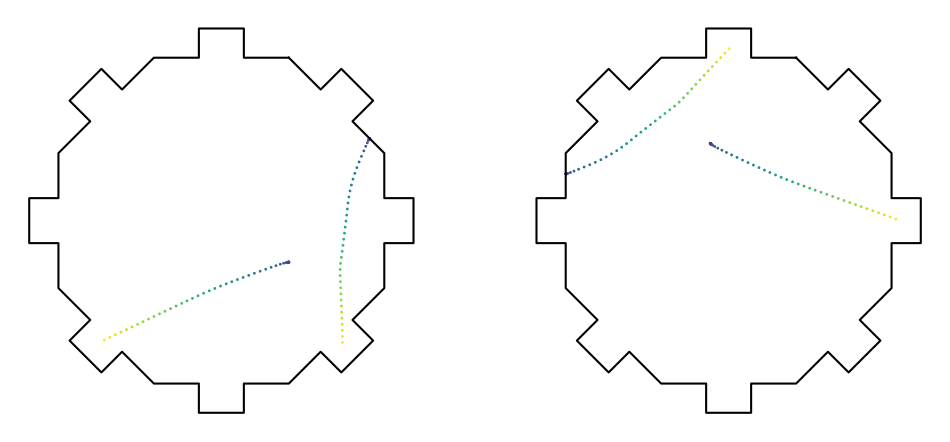

(4, 6, 6)

In [68]:
flipped_rotated_trajectory_testing_functions.plot_single_trial_flip_rotate_trajectories(trial_list, chosen_walls_session, 4, flip=True, scatter=True)

Plotting up to trial number: 55


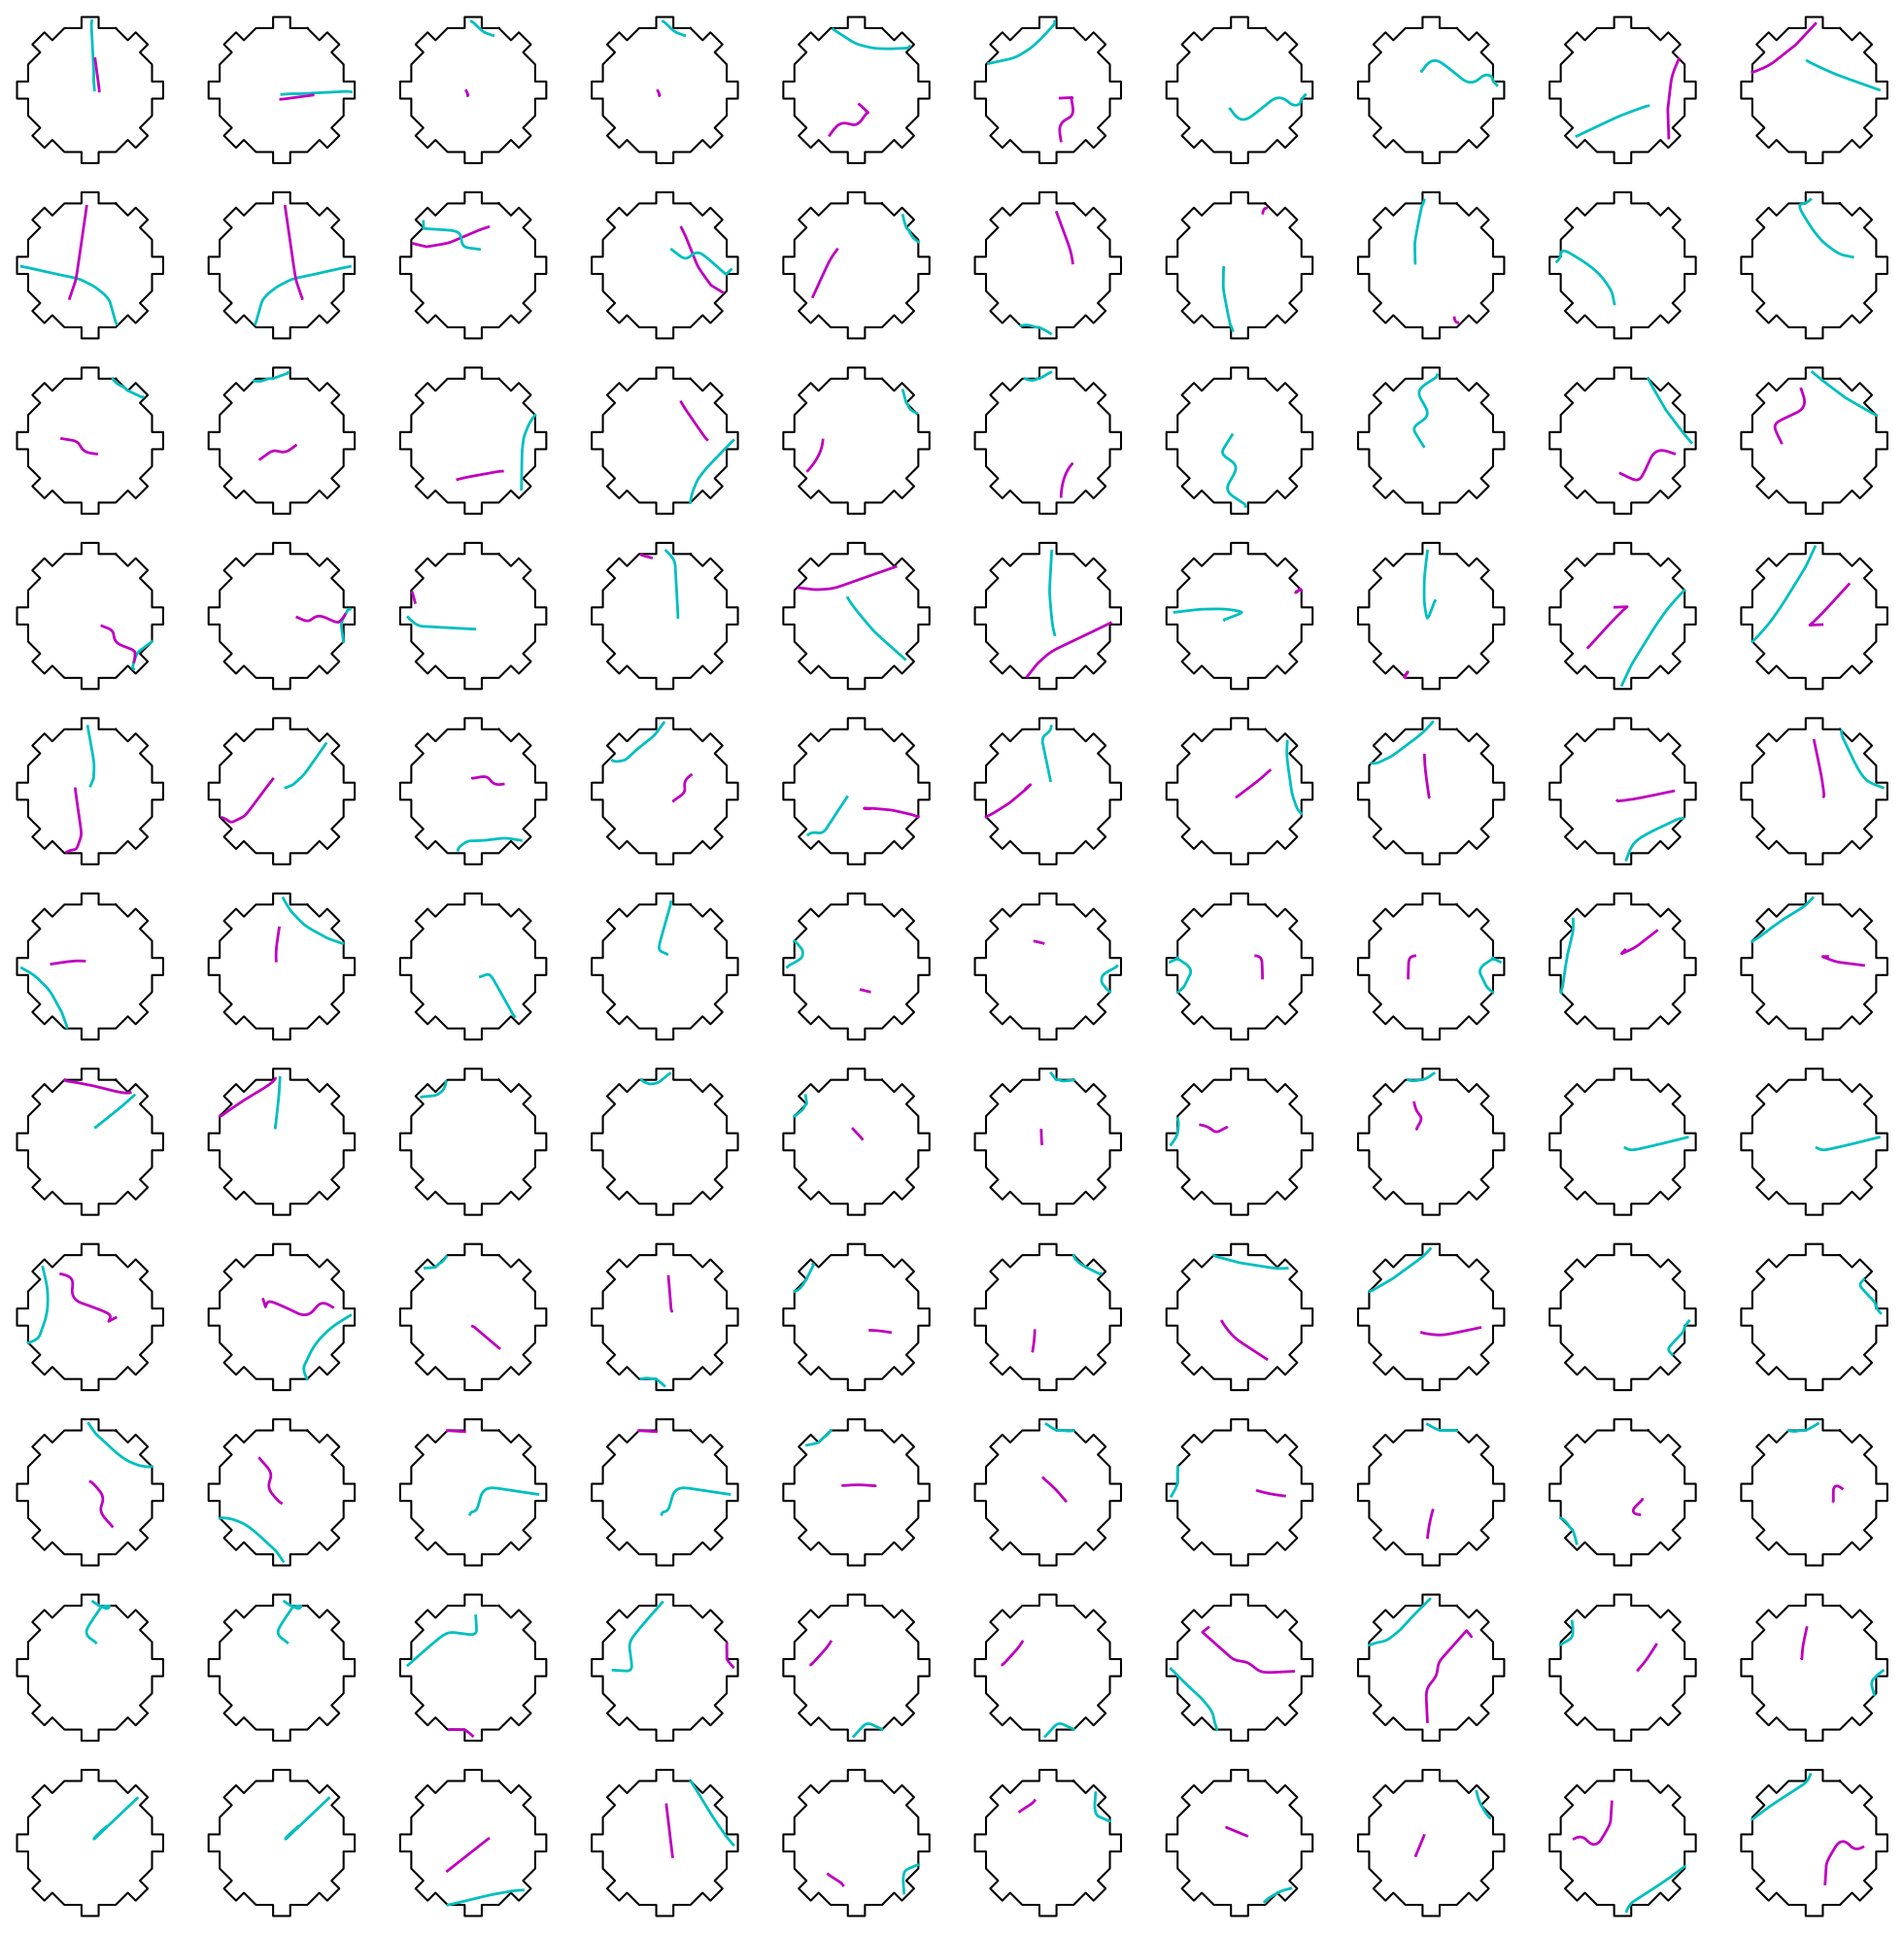

In [69]:

flipped_rotated_trajectory_testing_functions.plot_multiple_trials_flip_rotate_trajectories(trial_list, chosen_walls_session, rows=11, cols=10, trial_num_offset=0, flip=True)